# Extended SEIRS Workplace TTI Demo

**In this demonstration we will explore the effect of testing, tracing, and isolation interventions on disease transmission in a workplace setting with a realistic contact network.**

This notebook provides a demonstration of the functionality of the [Extended SEIRS Network Model](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description) and the [TTI Simulation Loop](https://github.com/ryansmcgee/seirsplus/wiki/TTI-Simulation-Loop). This notebook also offers a sandbox for starting to explore TTI scenarios of your own. 
For a more thorough walkthrough of the model, simulation loop, and use of this package, refer to the [SEIRS+ Wiki](https://github.com/ryansmcgee/seirsplus/wiki).

### Installing and importing the model code

All of the code needed to run the model is imported from the ```models``` module of this package.

In this demo we will also use features from the `networks`, `sim_loops`, and `utilities` modules.

#### Install the package using ```pip```
The package can be installed on your machine by entering this in the command line:

```pip install seirsplus```

Then, the ```models```, `networks`, `sim_loops`, and `utilities` modules can be imported as shown here:

In [1]:
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
import networkx
import matplotlib.pyplot as pyplot

#### *Alternatively, manually copy the code to your machine*
*You can use the model code without installing a package by copying the ```models.py``` module file to a directory on your machine. For some of the features used in this demo you will also need the `networks`, `sim_loops`, and `utilities` modules. In this case, the easiest way to use the modules is to place your scripts in the same directory as the modules, and import the modules as shown here:*
```python
from models import *
from networks import *
from sim_loops import *
from utilities import *
```

-------

## Set basic parameters

Specify the workplace size and structure

In [2]:
NUM_COHORTS              = 4
NUM_NODES_PER_COHORT     = 200
NUM_TEAMS_PER_COHORT     = 10

MEAN_INTRACOHORT_DEGREE  = 6
PCT_CONTACTS_INTERCOHORT = 0.1

In [3]:
N = NUM_NODES_PER_COHORT*NUM_COHORTS

Here we set the initial prevalence to be a single case

In [4]:
INIT_EXPOSED = 4

-------

## Specifying contact networks

This package implements models epidemic dynamics for populations with a structured [contact network](Extended-SEIRS-Model-Description#contact-networks). Individuals are represented as nodes in a network, and parameters, contacts, and interventions can be specified on a targeted individual basis. A graph specifying the contact network must be specified, where each node represents an individual in the population and edges connect individuals who have regular interactions.

This model also supports scenarios where individuals enter quarantine states in which their parameters and interactions may be different from baseline, and a separate graph defining the interactions for individuals in quarantine can be specified (i.e., the [quarantine contact network](Extended-SEIRS-Model-Description#quarantine-contacts)).

### Workplace Contact Network

Here we use the [**demographic community network generator**](https://github.com/ryansmcgee/seirsplus/wiki/Network-Generation#workplace-network) defined in the SEIRS+ package. This function generates a contact network that resembles workplaces and other multi-level modular populations.

[FARZ](https://github.com/ryansmcgee/seirsplus/wiki/Network-Generation#farz-networks) network layers are generated to represent cohorts of employees (e.g., departments, floors, shifts). FARZ networks have a tunable community structure, so each cohort includes some number of communities, which can be thought to represent teams (i.e., groups of employees that work closely with each other). Employees may belong to more than one team (specified by a FARZ parameter), but employees belong to only one cohort. An employee's intra-team and intra-cohort contacts are defined by the FARZ cohort network they belong to. A specified percentage of each employee's total number of workplace contacts can be with individuals from other cohorts. An employee's inter-cohort contacts are drawn randomly from the pool of individuals outside their own cohort. 

The number of cohorts, number of employees per cohort, number of teams per cohort, number of teams employees belong to, mean intra-cohort degree, percent of within- and between-team connections, and percent of intra- and inter-cohort connections can be controlled with the arguments to the `generate_demographic_contact_network()` function (some of which are passed as [parameters to the FARZ generator](https://github.com/ryansmcgee/seirsplus/wiki/Network-Generation#FARZ-parameters)).


Baseline:
Degree: mean = 11.11, std = 8.41, 95% CI = (1.00, 29.00)
        coeff var = 0.76
Assortativity:    0.28
Clustering coeff: 0.24



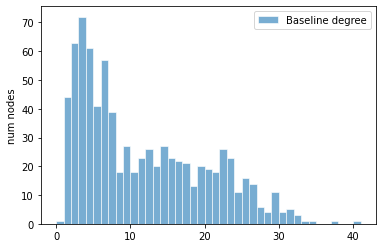

In [5]:
G_baseline, cohorts, teams = generate_workplace_contact_network(
                                 num_cohorts=NUM_COHORTS, num_nodes_per_cohort=NUM_NODES_PER_COHORT, 
                                 num_teams_per_cohort=NUM_TEAMS_PER_COHORT,
                                 mean_intracohort_degree=MEAN_INTRACOHORT_DEGREE, 
                                 pct_contacts_intercohort=PCT_CONTACTS_INTERCOHORT,
                                 farz_params={'alpha':5.0, 'gamma':5.0, 'beta':0.5, 'r':1, 'q':0.0, 'phi':10, 
                                              'b':0, 'epsilon':1e-6, 'directed': False, 'weighted': False})

network_info(G_baseline, "Baseline", plot=True)

Here we define the quarantine contact network to be an empty network (i.e., no connections). This represents an assumption that an employee that is in a quarantine state makes no contact with anyone from their workplace.

In [6]:
G_quarantine = networkx.classes.function.create_empty_copy(G_baseline)

-------

## Specifying parameters

**_The parameter values used in this notebook reflect rough estimates of parameter values for the COVID-19 epidemic (as of 9 Aug 2020)._**

### Set disease progression rate parameters:

Parameter values are assigned to members of the population on an individual basis. Parameter values can be [specified to the `ExtSEIRSNetworkModel`](https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-Class#specifying-parameters) by providing a list of values that gives the *N* values to assign to each individual. The population may be either homogeneous or heterogeneous for a given parameter at the user's discretion. 

**Here we generate distributions of values for each parameter, thus specifying a realistically heterogeneous population.**

Generate a distribution of expected latent periods (time in Exposed state) and presymptomatic periods (time in Pre-symptomatic infectious state). The `sigma` and `lamda` rates are calculated as the inverse of the expected exposed and pre-symptomatic periods assigned to each individual, respectively.

latent period:  mean = 2.19, std = 1.01, 95% CI = (0.71, 4.51)

pre-symptomatic period:  mean = 2.94, std = 1.72, 95% CI = (0.64, 7.12)

total incubation period:  mean = 5.14, std = 2.03, 95% CI = (2.17, 10.02)



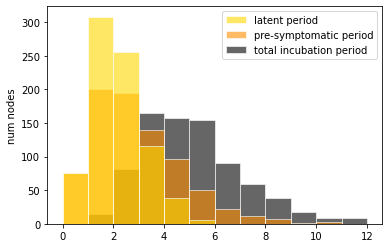

In [7]:
latentPeriod_mean, latentPeriod_coeffvar = 3.0, 0.6
SIGMA   = 1 / gamma_dist(latentPeriod_mean, latentPeriod_coeffvar, N)

presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar = 2.2, 0.5
LAMDA   = 1 / gamma_dist(presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar, N)

dist_info([1/LAMDA, 1/SIGMA, 1/LAMDA+1/SIGMA], ["latent period", "pre-symptomatic period", "total incubation period"], plot=True, colors=['gold', 'darkorange', 'black'], reverse_plot=True)

Generate a distribution of expected (a)symptomatic periods (time in symptomatic or asymptomatic state). The `gamma` rates are calculated as the inverse of the expected (a)symptomatic periods assigned to each individual. 

The expected total infectious period for each individual is the sum of their expected pre-symptomatic and (a)symptomatic periods.

pre-symptomatic period:  mean = 2.19, std = 1.01, 95% CI = (0.71, 4.51)

(a)symptomatic period:  mean = 4.01, std = 1.54, 95% CI = (1.64, 7.36)

total infectious period:  mean = 6.20, std = 1.87, 95% CI = (3.09, 10.45)



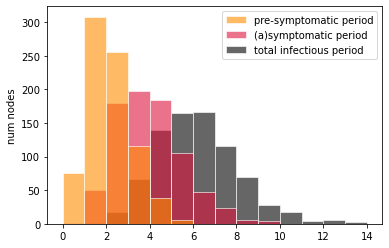

In [8]:
symptomaticPeriod_mean, symptomaticPeriod_coeffvar = 4.0, 0.4
GAMMA   = 1 / gamma_dist(symptomaticPeriod_mean, symptomaticPeriod_coeffvar, N)

infectiousPeriod = 1/LAMDA + 1/GAMMA

dist_info([1/LAMDA, 1/GAMMA, 1/LAMDA+1/GAMMA], ["pre-symptomatic period", "(a)symptomatic period", "total infectious period"], plot=True, colors=['darkorange', 'crimson', 'black'], reverse_plot=True)

Generate a distribution of expected onset-to-hospitalization periods (time in symptomatic state before entering hospitalized state for those with severe cases) and hospitalization-to-discharge periods (time in hospitalized state for those with non-fatal cases). The `eta` and `gamma_H` rates are calculated as the inverse of the expected onset-to-hospitalization periods and hospitalization-to-discharge periods assigned to each individual, respectively.

onset-to-hospitalization period:  mean = 11.12, std = 5.10, 95% CI = (3.72, 22.73)

hospitalization-to-discharge period:  mean = 11.38, std = 5.29, 95% CI = (3.49, 23.54)

onset-to-discharge period:  mean = 22.51, std = 7.16, 95% CI = (10.62, 39.43)



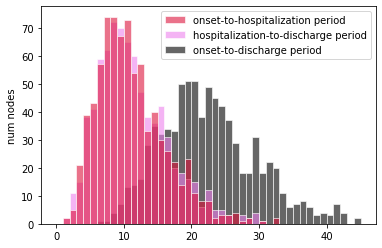

In [9]:
onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar = 11.0, 0.45
ETA     = 1 / gamma_dist(onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar, N)

hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar = 11.0, 0.45
GAMMA_H = 1 / gamma_dist(hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar, N)

dist_info([1/ETA, 1/GAMMA_H, 1/ETA+1/GAMMA_H], ["onset-to-hospitalization period", "hospitalization-to-discharge period", "onset-to-discharge period"], plot=True, colors=['crimson', 'violet', 'black'], reverse_plot=True)

Generate a distribution of hospitalization-to-death periods (time in hospitalized state for those with fatal cases). The `mu_H` rates are calculated as the inverse of the expected hospitalization-to-death periods.

onset-to-hospitalization period:  mean = 11.12, std = 5.10, 95% CI = (3.72, 22.73)

hospitalization-to-death period:  mean = 6.87, std = 3.10, 95% CI = (2.01, 13.61)

onset-to-death period:  mean = 17.99, std = 6.08, 95% CI = (8.34, 31.59)



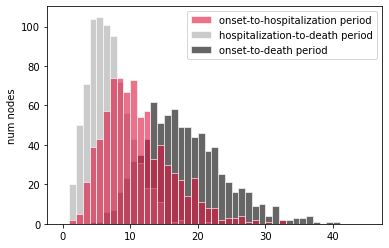

In [10]:
hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar = 7.0, 0.45
MU_H    = 1 / gamma_dist(hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar, N)

dist_info([1/ETA, 1/MU_H, 1/ETA+1/MU_H], ["onset-to-hospitalization period", "hospitalization-to-death period", "onset-to-death period"], plot=True, colors=['crimson', 'darkgray', 'black'], reverse_plot=True)

### Set severity parameters

Specify the percentage of cases that are asymptomatic. This percentage of case will progress from the pre-symptomatic state to the asymptomatic state, rather than to the symptomatic state.

In [11]:
PCT_ASYMPTOMATIC = 0.25

Here we specify the case hospitalization rate. The value used here is approximately the age-frequency-weighted average of age-stratified hospitalization rates for working age adults using data from [Verity et al. (2020)](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext).

In [12]:
PCT_HOSPITALIZED = 0.035

Here we specify the case fatality rate for hospitalized cases. The value used here is approximately the age-frequency-weighted average of age stratified hospitalization fatality rates for working age adults, again using figures from [Verity et al. (2020)](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext).

In [13]:
PCT_FATALITY = 0.08

### Set transmission parameters

The [Extended SEIRS Network Model](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#stochastic-network-model-implementation) model considers two modes of disease transmission: a well-mixed mode of [global transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#global-transmission) and a contact network based mode of [local transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#local-transmission). The propensity for a given individual to become exposed due to global transmission depends on the mean transmissibility of all infectious individuals in the population; the propensity for a given individual to become exposed due to local transmission depends on the pairwise transmissibilities between the focal node and its infectious contacts in the network (see [Transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#transmission) and [Model Equations](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#model-equations) for more information about these calculations). 

The transmissibility parameter *β* can be related to the basic reproduction number *R<sub>0</sub>* (i.e., the expected number of new infections generated by a single infectious individual in a completely susceptible population) by the standard formula: *β = R<sub>0</sub>𝛾*. *R<sub>0</sub>* is a more interpretable parameter, so we specify transmissibility in terms of *R<sub>0</sub>* and then calculate the corresponding *β* values.

First, we generate a distribution of individual *R<sub>0</sub>* values (i.e., the expected number of new infections generated by a single *particular* infectious individual in a completely susceptible population). Of course, this means that transmissibility is heterogeneous in this population. The coefficient of variation is an important parameter for the individual *R<sub>0</sub>* distribution in that it tunes the degree of superspreading in the heterogeneous transmissibility. The distribution used in this example has a relatively low coefficient of variation, so most individuals have around the same degree of transmissibility. But a higher coefficient of variation (e.g., 2.0) would give a long right tail in idividual transmissibility representing a small number of individuals contributing many cases while the majority cases contribute less than 1 on average when they are infectious.

Individual R0:  mean = 1.98, std = 0.41, 95% CI = (1.32, 2.89)



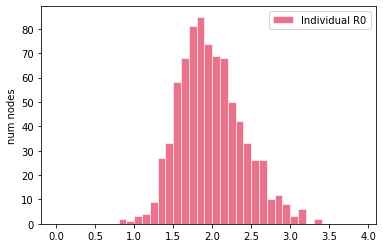

In [14]:
R0_mean     = 2.0
R0_coeffvar = 0.2

R0 = gamma_dist(R0_mean, R0_coeffvar, N)

dist_info(R0, "Individual R0", bin_size=0.1, plot=True, colors='crimson')

Individuals are ultimately assigned an [*Individual Transmissibility Value*](https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-Class#transmissibility-parameters) (*β<sup>i</sup>*), which are stored in the `beta` attribute of the model object. 

The means of the Individual Transmissibility Values for infectious subpopulations are used to calculate the [global transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#global-transmission) terms. Individual Transmissibility Values may also be used to generate the Pairwise Transmissibility Values used for [local transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#local-transmission) terms, as we will specify in a few steps.

In [15]:
BETA = 1/infectiousPeriod * R0

In the stochastic network model, an individual comes into contact with a random individual from the population at large (e.g., in a public space) with probability *p* or with an individual from their set of close contacts with probability *(1-p)*. Transmission that occurs between an individual and the population at large is referred to as [global transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#global-transmission), and transmission between an individual and one of their close contacts (network neighbors) is referred to as [local transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#local-transmission). The parameter *p* defines the locality of the network: for *p=0* an individual only interacts with their close contacts, while *p=1* represents a uniformly mixed population.

Here we set *p* to reflect 40% of interactions being with incidental or casual contacts outside their set of close contacts.

In [16]:
P_GLOBALINTXN = 0.4

### Set Testing, Tracing, & Isolation (TTI) intervention protocol parameters:

Here we specify the parameters that govern the Testing, Tracing, and Isolation protocol that is implemented by the [TTI Simulation Loop](https://github.com/ryansmcgee/seirsplus/wiki/TTI-Simulation-Loop). The implementation of this TTI protocol and the interpretation of these parameters is desribed in detail on the [TTI Simulation Loop wiki page](https://github.com/ryansmcgee/seirsplus/wiki/TTI-Simulation-Loop) (but these parameters are briefly explained as code comments below).

**The scenario set up in the steps that follow involves the entire workforce being tested on a weekly basis, a 2-day test turn around time, 50% of symptomatic individuals self-reporting and getting tested within 1 day of onset, 30% of symptomatics self-isolating even without a positive test, and teams of detected positive cases being proactively isolated. A new exogenous exposures comes into the workplace about once a week.**

In [17]:
INTERVENTION_START_PCT_INFECTED = 0/100
AVERAGE_INTRODUCTIONS_PER_DAY   = 1/14          # expected number of new exogenous exposures per day

TESTING_CADENCE                 = 'weekly'      # how often to do testing (other than self-reporting symptomatics who can get tested any day)
PCT_TESTED_PER_DAY              = 1.0           # max daily test allotment defined as a percent of population size
TEST_FALSENEG_RATE              = 'temporal'    # test false negative rate, will use FN rate that varies with disease time
MAX_PCT_TESTS_FOR_SYMPTOMATICS  = 1.0           # max percent of daily test allotment to use on self-reporting symptomatics
MAX_PCT_TESTS_FOR_TRACES        = 0.0           # max percent of daily test allotment to use on contact traces
RANDOM_TESTING_DEGREE_BIAS      = 0             # magnitude of degree bias in random selections for testing, none here

PCT_CONTACTS_TO_TRACE           = 0.0           # percentage of primary cases' contacts that are traced
TRACING_LAG                     = 2             # number of cadence testing days between primary tests and tracing tests

ISOLATION_LAG_SYMPTOMATIC       = 1             # number of days between onset of symptoms and self-isolation of symptomatics
ISOLATION_LAG_POSITIVE          = 2             # test turn-around time (TAT): number of days between administration of test and isolation of positive cases
ISOLATION_LAG_CONTACT           = 0             # number of days between a contact being traced and that contact self-isolating


### Set intervention compliance parameters

First, we specify the compliance rates (i.e., the percentage of individuals who are compliant) for each intervention type. See the [TTI Simulation Loop](https://github.com/ryansmcgee/seirsplus/wiki/TTI-Simulation-Loop) documentation for more information about compliance.

In [18]:
TESTING_COMPLIANCE_RATE_SYMPTOMATIC                  = 0.5    
TESTING_COMPLIANCE_RATE_TRACED                       = 0.0
TESTING_COMPLIANCE_RATE_RANDOM                       = 1.0  # Assume employee testing is mandatory, so 100% compliance

TRACING_COMPLIANCE_RATE                              = 0.0

ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_INDIVIDUAL     = 0.3
ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_GROUPMATE      = 0.0
ISOLATION_COMPLIANCE_RATE_POSITIVE_INDIVIDUAL        = 0.0
ISOLATION_COMPLIANCE_RATE_POSITIVE_GROUPMATE         = 0.8  # Isolate teams with a positive member, but suppose 20% of employees are essential workforce
ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACT           = 0.0
ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACTGROUPMATE  = 0.0

Now, we randomly assign a `True/False` compliance to each individual according to the rates set above. Individuals whose compliance is set to `True` for a given intervention will participate in that intervention, individuals set to `False` will not.

In [19]:
TESTING_COMPLIANCE_RANDOM                        = (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_RANDOM)
TESTING_COMPLIANCE_TRACED                        = (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_TRACED)
TESTING_COMPLIANCE_SYMPTOMATIC                   = (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_SYMPTOMATIC)

TRACING_COMPLIANCE                               = (numpy.random.rand(N) < TRACING_COMPLIANCE_RATE)

ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL      = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_INDIVIDUAL)
ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE       = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_GROUPMATE)
ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL         = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_INDIVIDUAL)
ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE          = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_GROUPMATE)
ISOLATION_COMPLIANCE_POSITIVE_CONTACT            = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACT)
ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE   = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACTGROUPMATE)

-------

## Initializing the model

In [26]:
model = ExtSEIRSNetworkModel(G=G_baseline, p=P_GLOBALINTXN,
                              beta=BETA, sigma=SIGMA, lamda=LAMDA, gamma=GAMMA, 
                              gamma_asym=GAMMA, eta=ETA, gamma_H=GAMMA_H, mu_H=MU_H, 
                              a=PCT_ASYMPTOMATIC, h=PCT_HOSPITALIZED, f=PCT_FATALITY,              
                              G_Q=G_quarantine, isolation_time=14,
                              initE=INIT_EXPOSED)

C:\Users\boaz\PycharmProjects\seirsplus\seirsplus\models.py:2143: RuntimeWarning: invalid value encountered in true_divide
  self.delta_Q             = numpy.log(self.degree_Q)/numpy.log(numpy.mean(self.degree_Q)) if self.parameters['delta_Q'] is None else numpy.array(self.parameters['delta_Q']) if isinstance(self.parameters['delta_Q'], (list, numpy.ndarray)) else numpy.full(fill_value=self.parameters['delta_Q'], shape=(self.numNodes,1))


-------

## Running the model

Set the max simulation time to 300 days.

In [27]:
T = 300

Execute the TTI simulation scenario by calling the `run_tti_sim()` function, which runs a custom simulation loop that implements the [TTI Simulation Protocol](https://github.com/ryansmcgee/seirsplus/wiki/TTI-Simulation-Loop).

In [28]:
run_tti_sim(model, T, 
            intervention_start_pct_infected=INTERVENTION_START_PCT_INFECTED, average_introductions_per_day=AVERAGE_INTRODUCTIONS_PER_DAY,
            testing_cadence=TESTING_CADENCE, pct_tested_per_day=PCT_TESTED_PER_DAY, test_falseneg_rate=TEST_FALSENEG_RATE, 
            testing_compliance_symptomatic=TESTING_COMPLIANCE_SYMPTOMATIC, max_pct_tests_for_symptomatics=MAX_PCT_TESTS_FOR_SYMPTOMATICS,
            testing_compliance_traced=TESTING_COMPLIANCE_TRACED, max_pct_tests_for_traces=MAX_PCT_TESTS_FOR_TRACES,
            testing_compliance_random=TESTING_COMPLIANCE_RANDOM, random_testing_degree_bias=RANDOM_TESTING_DEGREE_BIAS,
            tracing_compliance=TRACING_COMPLIANCE, pct_contacts_to_trace=PCT_CONTACTS_TO_TRACE, tracing_lag=TRACING_LAG,
            isolation_compliance_symptomatic_individual=ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL, isolation_compliance_symptomatic_groupmate=ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE, 
            isolation_compliance_positive_individual=ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL, isolation_compliance_positive_groupmate=ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE,
            isolation_compliance_positive_contact=ISOLATION_COMPLIANCE_POSITIVE_CONTACT, isolation_compliance_positive_contactgroupmate=ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE,
            isolation_lag_symptomatic=ISOLATION_LAG_SYMPTOMATIC, isolation_lag_positive=ISOLATION_LAG_POSITIVE, 
            isolation_groups=list(teams.values()),
            test_priority = 'last_tested')

[INTERVENTIONS @ t = 0.64 (4 (0.50%) infected)]


NameError: name 'sort' is not defined

In [23]:
results_summary(model)

total percent infected: 0.88%
total percent fatality: 0.00%
peak  pct hospitalized: 0.00%


-------

## Visualizing the results

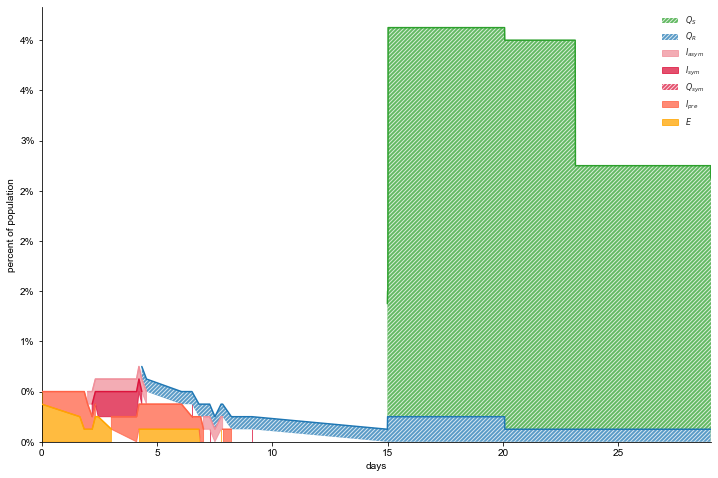

In [24]:
fig, ax = model.figure_infections(combine_Q_infected=False, plot_Q_R='stacked', plot_Q_S='stacked')